In [1]:
import rfcde

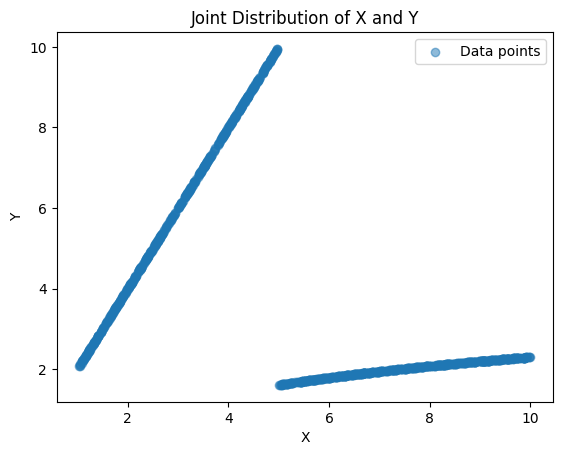

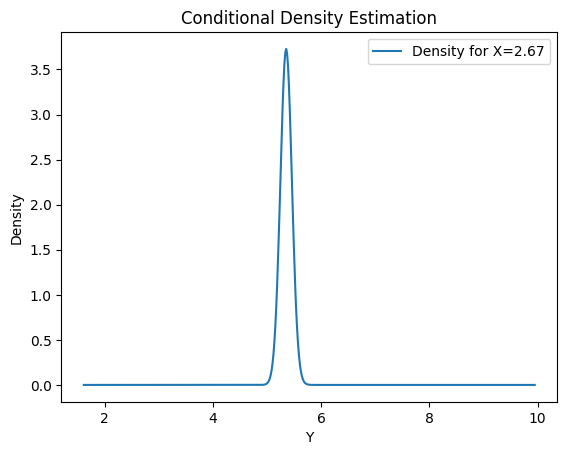

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rfcde import RFCDE

# Step 1: Create a small dataset of joint random variables (X, Y) with rules
np.random.seed(42)
n_samples = 1000

# Generate X
X = np.random.uniform(1, 10, n_samples)

# Define Y based on some rules
Y = np.where(X < 5, 2 * X, np.log(X))

# Combine X and Y into a DataFrame
data = pd.DataFrame({'X': X, 'Y': Y})

# Visualize the joint distribution
plt.scatter(X, Y, alpha=0.5, label="Data points")
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Joint Distribution of X and Y')
plt.legend()
plt.show()

# Step 2: Prepare data for RFCDE
x_train = data[['X']].values  # Predictor(s)
z_train = data['Y'].values  # Target

# Parameters for the RFCDE model
n_trees = 100
mtry = 1  # Number of features considered at each split
node_size = 5  # Minimum number of samples in a leaf node
n_basis = 31  # Number of basis functions for density estimation

# Initialize and train the RFCDE model
forest = RFCDE(n_trees=n_trees, mtry=mtry, node_size=node_size, n_basis=n_basis)
forest.train(x_train, z_train)

# Step 3: Predict conditional density for a random X in the sample space
bandwidth = 0.1  # Adjust bandwidth as needed
random_x = np.random.uniform(1, 10, 1).reshape(-1, 1)
y_values = np.linspace(Y.min(), Y.max(), 500)

# Predict the density
densities = forest.predict(random_x, y_values, bandwidth)

# Step 4: Visualize the density
plt.plot(y_values, densities[0], label=f"Density for X={random_x[0][0]:.2f}")
plt.xlabel('Y')
plt.ylabel('Density')
plt.title('Conditional Density Estimation')
plt.legend()
plt.show()


Minimized expected L1 distance: 12.52119059574707


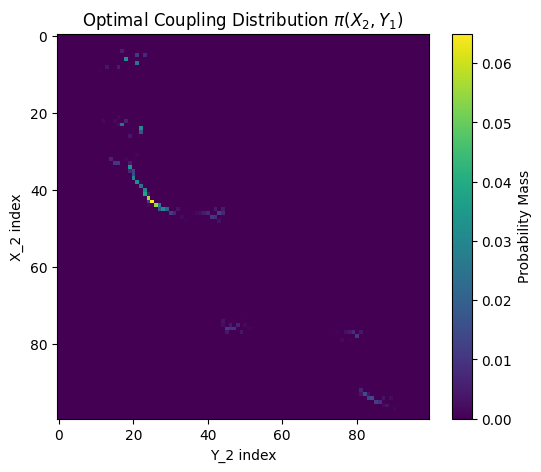

Time taken: 14.09 seconds


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rfcde import RFCDE
from scipy.optimize import linprog

import time

# Measure the time taken to run the provided code block
start_time = time.time()


# ---------------------------------------------------------
# STEP 1: Generate training data for (X_1, X_2) and (Y_1, Y_2)
# ---------------------------------------------------------
np.random.seed(42)

# Given sets:
X_1_values = np.array([-7, 8, 3, 4, 7, -33, 99, 66, -1, -14, -66])
Y_1_values = np.array([3, -1, 0, 98, 33, -7, -8, -2])

# Number of samples per X_1 and Y_1 for training:
n_samples_per_X1 = 4000
n_samples_per_Y1 = 5000

# Generate (X_1, X_2):
# For each X_1, we draw X_2 from Normal(X_1, 2)
X_1_train = []
X_2_train = []
for x1 in X_1_values:
    x2_samples = np.random.normal(loc=x1, scale=2, size=n_samples_per_X1)
    X_1_train.append(np.full(n_samples_per_X1, x1))
    X_2_train.append(x2_samples)

X_1_train = np.concatenate(X_1_train)
X_2_train = np.concatenate(X_2_train)

# Generate (Y_1, Y_2):
# For each Y_1, we draw Y_2 from Normal(Y_1, 5)
Y_1_train = []
Y_2_train = []
for y1 in Y_1_values:
    y2_samples = np.random.normal(loc=y1, scale=5, size=n_samples_per_Y1)
    Y_1_train.append(np.full(n_samples_per_Y1, y1))
    Y_2_train.append(y2_samples)

Y_1_train = np.concatenate(Y_1_train)
Y_2_train = np.concatenate(Y_2_train)

# ---------------------------------------------------------
# STEP 2: Fit RFCDE models
# Model 1: Estimate p(X_2 | X_1)
# Model 2: Estimate p(Y_2 | Y_1)
# ---------------------------------------------------------
n_trees = 100
mtry = 1
node_size = 5
n_basis = 31

# X_2 | X_1 model
X_forest = RFCDE(n_trees=n_trees, mtry=mtry, node_size=node_size, n_basis=n_basis)
# Convert X_1_train and X_2_train to float64
X_1_train = X_1_train.astype(np.float64)
X_2_train = X_2_train.astype(np.float64)

# Train the X_forest model
X_forest.train(X_1_train.reshape(-1, 1), X_2_train)

# Y_2 | Y_1 model
Y_forest = RFCDE(n_trees=n_trees, mtry=mtry, node_size=node_size, n_basis=n_basis)
Y_1_train = Y_1_train.astype(np.float64)
Y_2_train = Y_2_train.astype(np.float64)

Y_forest.train(Y_1_train.reshape(-1,1), Y_2_train)

# ---------------------------------------------------------
# STEP 3: Discretize the continuous distributions given by RFCDE
# For each unique X_1, discretize a grid of X_2 values
# For each unique Y_1, discretize a grid of Y_2 values
#
# We'll create a sufficiently large grid covering the ranges of X_2 and Y_2 observed.
# ---------------------------------------------------------
X2_min, X2_max = X_2_train.min()-3, X_2_train.max()+3
Y2_min, Y2_max = Y_2_train.min()-10, Y_2_train.max()+10

n_grid = 100  # number of grid points for discretization
X2_grid = np.linspace(X2_min, X2_max, n_grid)
Y2_grid = np.linspace(Y2_min, Y2_max, n_grid)

bandwidth_x = 0.5
bandwidth_y = 1.0

# Get conditional distributions:
# p(X_2 | X_1 = x_1) for each unique x_1 and p(Y_2 | Y_1 = y_1) for each unique y_1
#
# We'll store them in dictionaries for convenience.

X2_distributions = {}
for x1 in X_1_values:
    # Ensure x1 is converted to float64 and reshaped properly
    x1_float = np.array([[x1]], dtype=np.float64)

    # Ensure X2_grid and bandwidth_x are also float64 if needed
    X2_grid = X2_grid.astype(np.float64)
    bandwidth_x = float(bandwidth_x)  # If bandwidth_x is not already float

    # Call predict with the correct data types
    dens = X_forest.predict(x1_float, X2_grid, bandwidth_x)[0]

    dens = dens / (dens.sum() * (X2_grid[1]-X2_grid[0]))  # normalize to integrate to 1
    # Convert density to a discrete pmf over the grid:
    pmf = dens * (X2_grid[1]-X2_grid[0])
    X2_distributions[x1] = pmf

Y2_distributions = {}
for y1 in Y_1_values:
    # Ensure x1 is converted to float64 and reshaped properly
    y1_float = np.array([[y1]], dtype=np.float64)

    # Ensure X2_grid and bandwidth_x are also float64 if needed
    Y2_grid = Y2_grid.astype(np.float64)
    bandwidth_y = float(bandwidth_y)  # If bandwidth_x is not already float

    # Call predict with the correct data types
    dens = Y_forest.predict(y1_float, Y2_grid, bandwidth_y)[0]
    dens = dens / (dens.sum() * (Y2_grid[1]-Y2_grid[0]))
    pmf = dens * (Y2_grid[1]-Y2_grid[0])
    Y2_distributions[y1] = pmf

# ---------------------------------------------------------
# STEP 4: Construct overall distributions p(X_2) and p(Y_2)
#
# Now we must combine over all X_1 and Y_1. However, we haven't specified how we mix over X_1 and Y_1.
# Suppose we take X_1 and Y_1 to be equally likely among their sets.
#
# p(X_1) = uniform over X_1_values
# p(Y_1) = uniform over Y_1_values
#
# Then p(X_2) = sum_{x1} p(X_2|X_1=x1)*p(X_1=x1)
# Similarly for p(Y_2).
# ---------------------------------------------------------
p_X1 = np.ones(len(X_1_values)) / len(X_1_values)
p_Y1 = np.ones(len(Y_1_values)) / len(Y_1_values)

# Compute p(X_2):
pX2 = np.zeros(n_grid)
for i, x1 in enumerate(X_1_values):
    pX2 += X2_distributions[x1] * p_X1[i]

# Compute p(Y_2):
pY2 = np.zeros(n_grid)
for j, y1 in enumerate(Y_1_values):
    pY2 += Y2_distributions[y1] * p_Y1[j]

# ---------------------------------------------------------
# STEP 5: Optimal Transport Setup
#
# We want to find pi that minimizes E[|X_2 - Y_2|].
# Now we have discrete sets: {X_2_grid} and {Y_2_grid}, each with length n_grid.
#
# pX2 and pY2 are the marginals.
#
# Cost matrix C[i,j] = |X_2_grid[i] - Y_2_grid[j]|
# ---------------------------------------------------------
C = np.abs(X2_grid[:, None] - Y2_grid[None, :])

# We must solve:
# minimize sum_{i,j} pi_{ij} * C[i,j]
# subject to sum_j pi_{ij} = pX2[i]
#            sum_i pi_{ij} = pY2[j]
# pi_{ij} >= 0

# Construct A_eq and b_eq for linear constraints:
A_eq = []
b_eq = []

# Row constraints: for each i in X_2
for i in range(n_grid):
    row_constraint = np.zeros(n_grid*n_grid)
    row_constraint[i*n_grid:(i+1)*n_grid] = 1
    A_eq.append(row_constraint)
    b_eq.append(pX2[i])

# Column constraints: for each j in Y_2
for j in range(n_grid):
    col_constraint = np.zeros(n_grid*n_grid)
    col_constraint[j::n_grid] = 1
    A_eq.append(col_constraint)
    b_eq.append(pY2[j])

A_eq = np.array(A_eq)
b_eq = np.array(b_eq)

bounds = [(0, None)]*(n_grid*n_grid)

res = linprog(C.flatten(), A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')
if not res.success:
    raise ValueError("Optimization failed")

pi_opt = res.x.reshape(n_grid, n_grid)

# ---------------------------------------------------------
# STEP 6: Compute minimized expected L1 difference
# ---------------------------------------------------------
expected_L1 = (pi_opt * C).sum()
print("Minimized expected L1 distance:", expected_L1)

# ---------------------------------------------------------
# Optional: Visualize the optimal transport plan
# ---------------------------------------------------------
plt.figure(figsize=(6,5))
plt.imshow(pi_opt, aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar(label='Probability Mass')
plt.xlabel('Y_2 index')
plt.ylabel('X_2 index')
plt.title('Optimal Coupling Distribution $\pi(X_2, Y_1)$')
plt.show()

end_time = time.time()
print("Time taken: {:.2f} seconds".format(end_time - start_time))

# ---------------------------------------------------------
# Explanation:
# - We generated continuous data and trained RFCDE models.
# - We discretized the conditional densities obtained from RFCDE.
# - We formed marginals over X_2 and Y_2.
# - We solved an optimal transport problem to find the distribution pi that minimizes E[|X_2 - Y_2|].

In [10]:
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# STEP 1: Generate training data
# ---------------------------------------------------------
# Measure the time taken to run the provided code block
start_time = time.time()
np.random.seed(49)

# Given sets:
X_1_values = np.array([-7, 8, 3, 4, 7, -33, 99, 66, -1, -14, -66])
Y_1_values = np.array([3, -1, 0, 98, 33, -7, -8, -2])

n_samples_per_X1 = 4000
n_samples_per_Y1 = 5000

# Define fixed distributions for X_2|X_1 and Y_2|Y_1
conditional_X2 = {x1: np.random.normal(loc=x1, scale=2, size=n_samples_per_X1) for x1 in X_1_values}
conditional_Y2 = {y1: np.random.normal(loc=y1, scale=5, size=n_samples_per_Y1) for y1 in Y_1_values}

# ---------------------------------------------------------
# STEP 2: Discretize the distributions
# ---------------------------------------------------------
X2_grid = np.linspace(-15, 15, 100)
Y2_grid = np.linspace(-30, 110, 100)

# p(X_2 | X_1) and p(Y_2 | Y_1)
pX2_given_X1 = {x1: np.histogram(conditional_X2[x1], bins=X2_grid, density=True)[0] for x1 in X_1_values}
pY2_given_Y1 = {y1: np.histogram(conditional_Y2[y1], bins=Y2_grid, density=True)[0] for y1 in Y_1_values}

# Marginal probabilities for X_1 and Y_1 (uniform)
pX1 = np.ones(len(X_1_values)) / len(X_1_values)
pY1 = np.ones(len(Y_1_values)) / len(Y_1_values)

# Compute p(X_2) and p(Y_2)
pX2 = np.zeros(len(X2_grid) - 1)
for i, x1 in enumerate(X_1_values):
    pX2 += pX2_given_X1[x1] * pX1[i]

pY2 = np.zeros(len(Y2_grid) - 1)
for j, y1 in enumerate(Y_1_values):
    pY2 += pY2_given_Y1[y1] * pY1[j]
    

pX2 /= np.sum(pX2)
pY2 /= np.sum(pY2)

# ---------------------------------------------------------
# STEP 3: Construct the cost matrix
# ---------------------------------------------------------
C = np.abs(X2_grid[:-1, None] - Y2_grid[:-1])  # Cost matrix |X_2 - Y_2|

# ---------------------------------------------------------
# STEP 4: Set up the linear program
# ---------------------------------------------------------
n_X2 = len(X2_grid) - 1
n_Y2 = len(Y2_grid) - 1

# Equality constraints for marginals
A_eq = []
b_eq = []

# Row constraints: p(X_2)
for i in range(n_X2):
    row_constraint = np.zeros(n_X2 * n_Y2)
    row_constraint[i * n_Y2:(i + 1) * n_Y2] = 1
    A_eq.append(row_constraint)
    b_eq.append(pX2[i])

# Column constraints: p(Y_2)
for j in range(n_Y2):
    col_constraint = np.zeros(n_X2 * n_Y2)
    col_constraint[j::n_Y2] = 1
    A_eq.append(col_constraint)
    b_eq.append(pY2[j])

A_eq = np.array(A_eq)
b_eq = np.array(b_eq)

# Bounds for the optimization variables (pi_ij >= 0)
bounds = [(0, None)] * (n_X2 * n_Y2)

# ---------------------------------------------------------
# Solve the linear program
# ---------------------------------------------------------
res = linprog(C.flatten(), A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

if not res.success:
    raise ValueError("Optimization failed")

# Optimal transport plan
pi_opt = res.x.reshape(n_X2, n_Y2)

# ---------------------------------------------------------
# STEP 5: Compute minimized expected L1 distance
# ---------------------------------------------------------
expected_L1 = (pi_opt * C).sum()
print("Minimized expected L1 distance:", expected_L1)

# ---------------------------------------------------------
# Optional: Visualize the optimal transport plan
# ---------------------------------------------------------
plt.figure(figsize=(8, 6))
plt.imshow(pi_opt, aspect='auto', cmap='viridis', interpolation='nearest', origin='lower')
plt.colorbar(label='Probability Mass')
plt.xlabel('Y_2 index')
plt.ylabel('X_2 index')
plt.title('Optimal Coupling Distribution $\pi(X_2, Y_2)$')
plt.show()

end_time = time.time()
print("Time taken: {:.2f} seconds".format(end_time - start_time))

ValueError: Invalid input for linprog: b_eq must not contain values inf, nan, or None